In [1]:
# Import necessary modules for data analysis and data visualization. 
# Data analysis modules

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings                      ## importing warnings library. 
warnings.filterwarnings('ignore')    ## Ignore warning

In [2]:
train = pd.read_csv("./datasets/titanic/train.csv")
test = pd.read_csv("./datasets/titanic/test.csv")

In [3]:
## Take a look at the overview of the dataset. 
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
652,653,0,3,"Kalvik, Mr. Johannes Halvorsen",male,21.0,0,0,8475,8.4333,NaN,S
101,102,0,3,"Petroff, Mr. Pastcho (""Pentcho"")",male,NaN,0,0,349215,7.8958,NaN,S
320,321,0,3,"Dennis, Mr. Samuel",male,22.0,0,0,A/5 21172,7.2500,NaN,S
814,815,0,3,"Tomlin, Mr. Ernest Portage",male,30.5,0,0,364499,8.0500,NaN,S
867,868,0,1,"Roebling, Mr. Washington Augustus II",male,31.0,0,0,PC 17590,50.4958,A24,S


In [4]:
test.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
401,1293,2,"Gale, Mr. Harry",male,38.0,1,0,28664,21.0000,NaN,S
214,1106,3,"Andersson, Miss. Ida Augusta Margareta",female,38.0,4,2,347091,7.7750,NaN,S
90,982,3,"Dyker, Mrs. Adolf Fredrik (Anna Elisabeth Judi...",female,22.0,1,0,347072,13.9000,NaN,S
25,917,3,"Robins, Mr. Alexander A",male,50.0,1,0,A/5. 3337,14.5000,NaN,S
98,990,3,"Braf, Miss. Elin Ester Maria",female,20.0,0,0,347471,7.8542,NaN,S


In [5]:
## saving passenger id in advance in order to submit later. 
passengerid = test.PassengerId

## Replacing the null values in the Embarked column with the mode. 
train.Embarked.fillna("C", inplace=True)

## Concat train and test into a variable "all_data"
survivers = train.Survived

train.drop(["Survived"],axis=1, inplace=True)

all_data = pd.concat([train,test], ignore_index=False)

## Assign all the null values to N
all_data.Cabin.fillna("N", inplace=True)

all_data.Cabin = [i[0] for i in all_data.Cabin]

with_N = all_data[all_data.Cabin == "N"]

without_N = all_data[all_data.Cabin != "N"]

all_data.groupby("Cabin")['Fare'].mean().sort_values()

def cabin_estimator(i):
    a = 0
    if i<16:
        a = "G"
    elif i>=16 and i<27:
        a = "F"
    elif i>=27 and i<38:
        a = "T"
    elif i>=38 and i<47:
        a = "A"
    elif i>= 47 and i<53:
        a = "E"
    elif i>= 53 and i<54:
        a = "D"
    elif i>=54 and i<116:
        a = 'C'
    else:
        a = "B"
    return a
    

##applying cabin estimator function. 
with_N['Cabin'] = with_N.Fare.apply(lambda x: cabin_estimator(x))

## getting back train. 
all_data = pd.concat([with_N, without_N], axis=0)

## PassengerId helps us separate train and test. 
all_data.sort_values(by = 'PassengerId', inplace=True)

## Separating train and test from all_data. 
train = all_data[:891]

test = all_data[891:]

# adding saved target variable with train. 
train['Survived'] = survivers

missing_value = test[(test.Pclass == 3) & (test.Embarked == "S") & (test.Sex == "male")].Fare.mean()
## replace the test.fare null values with test.fare mean
test.Fare.fillna(missing_value, inplace=True)

## dropping the three outliers where Fare is over $500 
train = train[train.Fare < 500]

# Placing 0 for female and 
# 1 for male in the "Sex" column. 
train['Sex'] = train.Sex.apply(lambda x: 0 if x == "female" else 1)
test['Sex'] = test.Sex.apply(lambda x: 0 if x == "female" else 1)

# Creating a new colomn with a 
train['name_length'] = [len(i) for i in train.Name]
test['name_length'] = [len(i) for i in test.Name]

def name_length_group(size):
    a = ''
    if (size <=20):
        a = 'short'
    elif (size <=35):
        a = 'medium'
    elif (size <=45):
        a = 'good'
    else:
        a = 'long'
    return a


train['nLength_group'] = train['name_length'].map(name_length_group)
test['nLength_group'] = test['name_length'].map(name_length_group)

## Here "map" is python's built-in function. 
## "map" function basically takes a function and 
## returns an iterable list/tuple or in this case series. 
## However,"map" can also be used like map(function) e.g. map(name_length_group) 
## or map(function, iterable{list, tuple}) e.g. map(name_length_group, train[feature]]). 
## However, here we don't need to use parameter("size") for name_length_group because when we 
## used the map function like ".map" with a series before dot, we are basically hinting that series 
## and the iterable. This is similar to .append approach in python. list.append(a) meaning applying append on list. 

## cuts the column by given bins based on the range of name_length
#group_names = ['short', 'medium', 'good', 'long']
#train['name_len_group'] = pd.cut(train['name_length'], bins = 4, labels=group_names)

## Title
## get the title from the name
train["title"] = [i.split('.')[0] for i in train.Name]
train["title"] = [i.split(',')[1] for i in train.title]
test["title"] = [i.split('.')[0] for i in test.Name]
test["title"]= [i.split(',')[1] for i in test.title]

#rare_title = ['the Countess','Capt','Lady','Sir','Jonkheer','Don','Major','Col']
#train.Name = ['rare' for i in train.Name for j in rare_title if i == j]
## train Data
train["title"] = [i.replace('Ms', 'Miss') for i in train.title]
train["title"] = [i.replace('Mlle', 'Miss') for i in train.title]
train["title"] = [i.replace('Mme', 'Mrs') for i in train.title]
train["title"] = [i.replace('Dr', 'rare') for i in train.title]
train["title"] = [i.replace('Col', 'rare') for i in train.title]
train["title"] = [i.replace('Major', 'rare') for i in train.title]
train["title"] = [i.replace('Don', 'rare') for i in train.title]
train["title"] = [i.replace('Jonkheer', 'rare') for i in train.title]
train["title"] = [i.replace('Sir', 'rare') for i in train.title]
train["title"] = [i.replace('Lady', 'rare') for i in train.title]
train["title"] = [i.replace('Capt', 'rare') for i in train.title]
train["title"] = [i.replace('the Countess', 'rare') for i in train.title]
train["title"] = [i.replace('Rev', 'rare') for i in train.title]



#rare_title = ['the Countess','Capt','Lady','Sir','Jonkheer','Don','Major','Col']
#train.Name = ['rare' for i in train.Name for j in rare_title if i == j]
## test data
test['title'] = [i.replace('Ms', 'Miss') for i in test.title]
test['title'] = [i.replace('Dr', 'rare') for i in test.title]
test['title'] = [i.replace('Col', 'rare') for i in test.title]
test['title'] = [i.replace('Dona', 'rare') for i in test.title]
test['title'] = [i.replace('Rev', 'rare') for i in test.title]

## Family_size seems like a good feature to create
train['family_size'] = train.SibSp + train.Parch+1
test['family_size'] = test.SibSp + test.Parch+1

def family_group(size):
    a = ''
    if (size <= 1):
        a = 'loner'
    elif (size <= 4):
        a = 'small'
    else:
        a = 'large'
    return a

train['family_group'] = train['family_size'].map(family_group)
test['family_group'] = test['family_size'].map(family_group)

train['is_alone'] = [1 if i<2 else 0 for i in train.family_size]
test['is_alone'] = [1 if i<2 else 0 for i in test.family_size]

train.drop(['Ticket'], axis=1, inplace=True)

test.drop(['Ticket'], axis=1, inplace=True)

## Calculating fare based on family size. 
train['calculated_fare'] = train.Fare/train.family_size
test['calculated_fare'] = test.Fare/test.family_size

def fare_group(fare):
    a= ''
    if fare <= 4:
        a = 'Very_low'
    elif fare <= 10:
        a = 'low'
    elif fare <= 20:
        a = 'mid'
    elif fare <= 45:
        a = 'high'
    else:
        a = "very_high"
    return a

train['fare_group'] = train['calculated_fare'].map(fare_group)
test['fare_group'] = test['calculated_fare'].map(fare_group)

#train['fare_group'] = pd.cut(train['calculated_fare'], bins = 4, labels=groups)

train.drop(['PassengerId'], axis=1, inplace=True)

test.drop(['PassengerId'], axis=1, inplace=True)


train = pd.get_dummies(train, columns=['title',"Pclass", 'Cabin','Embarked','nLength_group', 'family_group', 'fare_group'], drop_first=False)
test = pd.get_dummies(test, columns=['title',"Pclass",'Cabin','Embarked','nLength_group', 'family_group', 'fare_group'], drop_first=False)
train.drop(['family_size','Name', 'Fare','name_length'], axis=1, inplace=True)
test.drop(['Name','family_size',"Fare",'name_length'], axis=1, inplace=True)

## rearranging the columns so that I can easily use the dataframe to predict the missing age values. 
train = pd.concat([train[["Survived", "Age", "Sex","SibSp","Parch"]], train.loc[:,"is_alone":]], axis=1)
test = pd.concat([test[["Age", "Sex"]], test.loc[:,"SibSp":]], axis=1)

## Importing RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

## writing a function that takes a dataframe with missing values and outputs it by filling the missing values. 
def completing_age(df):
    ## gettting all the features except survived
    age_df = df.loc[:,"Age":] 
    
    temp_train = age_df.loc[age_df.Age.notnull()] ## df with age values
    temp_test = age_df.loc[age_df.Age.isnull()] ## df without age values
    
    y = temp_train.Age.values ## setting target variables(age) in y 
    x = temp_train.loc[:, "Sex":].values
    
    rfr = RandomForestRegressor(n_estimators=1500, n_jobs=-1)
    rfr.fit(x, y)
    
    predicted_age = rfr.predict(temp_test.loc[:, "Sex":])
    
    df.loc[df.Age.isnull(), "Age"] = predicted_age
    

    return df

## Implementing the completing_age function in both train and test dataset. 
completing_age(train)
completing_age(test);

## create bins for age
def age_group_fun(age):
    a = ''
    if age <= 1:
        a = 'infant'
    elif age <= 4: 
        a = 'toddler'
    elif age <= 13:
        a = 'child'
    elif age <= 18:
        a = 'teenager'
    elif age <= 35:
        a = 'Young_Adult'
    elif age <= 45:
        a = 'adult'
    elif age <= 55:
        a = 'middle_aged'
    elif age <= 65:
        a = 'senior_citizen'
    else:
        a = 'old'
    return a
        
## Applying "age_group_fun" function to the "Age" column.
train['age_group'] = train['Age'].map(age_group_fun)
test['age_group'] = test['Age'].map(age_group_fun)

## Creating dummies for "age_group" feature. 
train = pd.get_dummies(train,columns=['age_group'], drop_first=True)
test = pd.get_dummies(test,columns=['age_group'], drop_first=True);

"""train.drop('Age', axis=1, inplace=True)
test.drop('Age', axis=1, inplace=True)"""

# separating our independent and dependent variable
X = train.drop(['Survived'], axis = 1)
y = train["Survived"]


#age_filled_data_nor = NuclearNormMinimization().complete(df1)
#Data_1 = pd.DataFrame(age_filled_data, columns = df1.columns)
#pd.DataFrame(zip(Data["Age"],Data_1["Age"],df["Age"]))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .33, random_state = 0)

# Feature Scaling
## We will be using standardscaler to transform
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

## transforming "train_x"
train_x = sc.fit_transform(X_train)
## transforming "test_x"
test_x = sc.transform(X_test)

## transforming "The testset"
test = sc.transform(test)

## changing calculated_fare type
train.calculated_fare = train.calculated_fare.astype(float)

## Using StratifiedShuffleSplit
## We can use KFold, StratifiedShuffleSplit, StratiriedKFold or ShuffleSplit, They are all close cousins. look at sklearn userguide for more info.   
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
cv = StratifiedShuffleSplit(n_splits = 10, test_size = .25, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%
## Using standard scale for the whole dataset.

## saving the feature names for decision tree display
column_names = X.columns

X = sc.fit_transform(X)

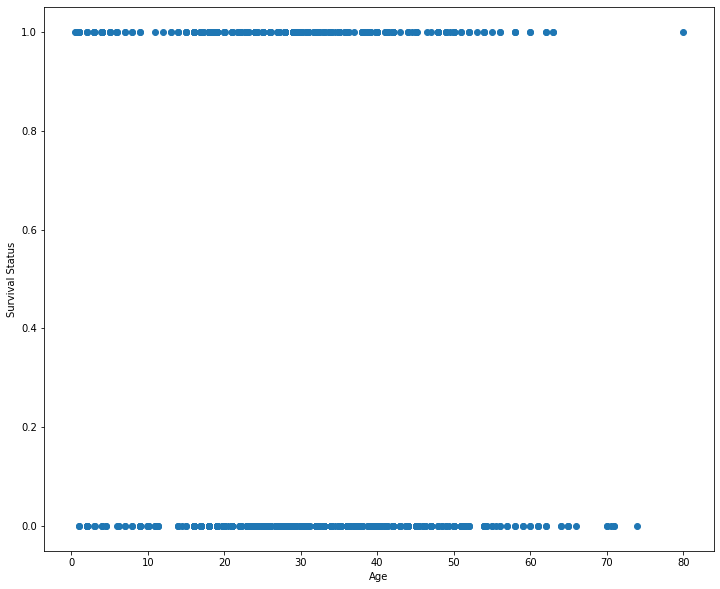

In [6]:
plt.subplots(figsize = (12,10))
plt.scatter(train.Age, train.Survived);
plt.xlabel("Age")
plt.ylabel('Survival Status');

In [7]:
# import LogisticRegression model in python. 
from core.models import LogisticRegression
from sklearn.metrics import mean_absolute_error, classification_report

from sklearn.linear_model import LogisticRegression as LR
## call on the model object
logreg = LogisticRegression()
## fit the model with "train_x" and "train_y"
logreg.fit(X_train,y_train)

## Once the model is trained we want to find out how well the model is performing, so we test the model. 
## we use "test_x" portion of the data(this data was not used to fit the model) to predict model outcome. 
y_pred = logreg.predict(X_test)

## Once predicted we save that outcome in "y_pred" variable.
## Then we compare the predicted value( "y_pred") and actual value("test_y") to see how well our model is performing. 

print ("Our model accuracy Score is: \n", classification_report(y_test, y_pred))

model = LR()
model.fit(X_train, y_train)

y_pred1 = model.predict(X_test)
print ("Built in model accuracy Score is: \n", classification_report(y_test, y_pred1))

Our model accuracy Score is: 
               precision    recall  f1-score   support

           0       0.86      0.76      0.81       177
           1       0.69      0.82      0.75       117

    accuracy                           0.78       294
   macro avg       0.78      0.79      0.78       294
weighted avg       0.80      0.78      0.78       294

Built in model accuracy Score is: 
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       177
           1       0.75      0.73      0.74       117

    accuracy                           0.80       294
   macro avg       0.79      0.78      0.79       294
weighted avg       0.79      0.80      0.80       294

